In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
#from sklearn.metrics import roc_curve, auc, RocCurveDisplay, precision_recall_curve, PrecisionRecallDisplay
#from helpers import read_metrics_csvs, read_fastas
import math
from sklearn.metrics import roc_curve, auc, RocCurveDisplay, precision_recall_curve, PrecisionRecallDisplay
import matplotlib as mpl
from IPython import display
from collections import OrderedDict

import urllib.request

from pathlib import Path


In [2]:
MAIN_TEXT_METRICS = ["CARP-640m", "ESM-1v", "ESM-MSA", "BLOSUM62", "Identity", "Rosetta-relax", "ESM-IF", "ProteinMPNN", "MIF-ST", "AlphaFold2 pLDDT"]
ALL_METRICS = ["CARP-640m", "ESM-1v", "ESM-1v mask6", "ESM-MSA", "BLOSUM62", "PFASUM15", "Identity", "Rosetta-relax", "ESM-IF", "ProteinMPNN", "MIF-ST", "AlphaFold2 pLDDT"]#, "longest_repeat_1", "longest_repeat_2"]
MODEL_HUE_ORDER = ["test", "ASR", "GAN", "ESM-MSA"]
ACTIVITY_STYLE_ORDER = [0,1]
ROUND_HUE_ORDER = ["round1","round2"]
SET_HUE_ORDER = ["passing","control"]

heatmap_cmap="Blues"

# "9467bd" # purple
# "17becf" # teal

set_colors_map=OrderedDict([
    ("passing","#17becf"),
    ("control","#9467bd"),
    ("round 2","black")
])


In [3]:
metrics_path = Path("../data/experimentally_tested_metrics.csv")

if not metrics_path.exists():
    urllib.request.urlretrieve("https://zenodo.org/record/7688668/files/experimentally_tested_metrics.csv", metrics_path)

experimentally_tested_metrics = pd.read_csv(metrics_path)
outdir = "figs"

# main text figures

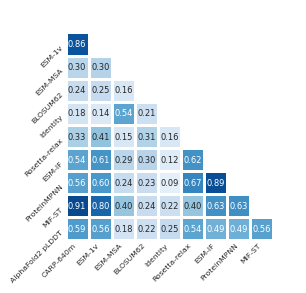

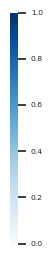

In [4]:
# Average spearman

_ = sns.set(font_scale=0.5)
_ = sns.set_style('white')

MDH_df = experimentally_tested_metrics[
    (experimentally_tested_metrics['Round'] == 'round2') &
    (experimentally_tested_metrics['Model'] != "pre-test" ) &
    (experimentally_tested_metrics['Family'] == "MDH")
]

CuSOD_df = experimentally_tested_metrics[
    (experimentally_tested_metrics['Round'] == 'round2') &
    (experimentally_tested_metrics['Model'] != "pre-test" ) &
    (experimentally_tested_metrics['Family'] == "CuSOD")
]

MDH_spearman = MDH_df[MAIN_TEXT_METRICS].corr("spearman")
CuSOD_spearman = CuSOD_df[MAIN_TEXT_METRICS].corr("spearman")

average_spearman = (MDH_spearman + CuSOD_spearman) / 2

fig, ax = plt.subplots(figsize=(3, 3))
mask = np.triu(average_spearman)
fig2, ax2 = plt.subplots(figsize=(0.1, 3))
_ = sns.heatmap(average_spearman, annot=True, fmt='.2f', linewidths=1, linecolor="white", cmap=heatmap_cmap,
            vmin=0, vmax=1, ax=ax, mask=mask, square=True, cbar_ax=ax2)
ax.set_xticks(ax.get_xticks()[:-1], ax.get_xticklabels()[:-1], rotation=45, ha='right')
ax.set_yticks(ax.get_yticks()[1:], ax.get_yticklabels()[1:], rotation=45, va='top')
ax.tick_params(pad=-5)
fig.savefig(f"{outdir}/round2_main_text_metrics_average_spearman.png", dpi=300, bbox_inches='tight')
fig2.savefig(f"{outdir}/round2_main_text_metrics_average_spearman_cbar.png", dpi=300, bbox_inches='tight')


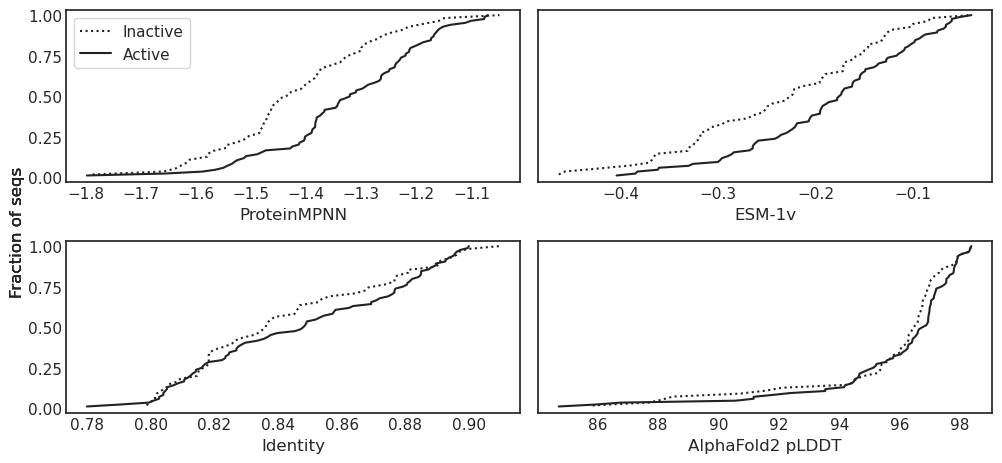

In [5]:
def ecdf(data, array: bool=True):
    """Compute ECDF for a one-dimensional array of measurements."""
    # Number of data points: n
    n = len(data)
    # x-data for the ECDF: x
    x = np.sort(data)
    # y-data for the ECDF: y
    y = np.arange(1, n+1) / n
    if not array:
        return pd.DataFrame({'x': x, 'y': y})
    else:
        return x, y

_ = sns.set(font_scale=1.0)
_ = sns.set_style('white')
fig, axs = plt.subplots(2, 2, sharey='row', figsize=(10, 4.8))
for idx, (metric, family) in enumerate((("ProteinMPNN", ""), ("ESM-1v", ""), ("Identity", ""), ("AlphaFold2 pLDDT", ""))):
    df = experimentally_tested_metrics[
        (experimentally_tested_metrics['Round'] == 'round2') &
        (experimentally_tested_metrics['Model'] != "pre-test")
        ]
    df = df.groupby('Activity')[metric].apply(ecdf, False).reset_index(level=0).reset_index(drop=True)
    ax = axs.ravel()[idx]
    for a, (m, la) in enumerate(zip([':', '-'], ['Inactive', 'Active'])):
        _ = ax.plot(df[df['Activity'] == a]['x'], df[df['Activity'] == a]['y'], m, label=la, color='#222222')
    if idx == 0:
        _ = ax.legend()
    ax.set_ylim([-0.03, 1.03])
    ax.tick_params(left=False, bottom=False, pad=-3)
    # ax.set(yticklabels=[], xticklabels=[])
    fig.text(0.0, 0.5, 'Fraction of seqs', va='center', rotation='vertical')

    # if idx % 2 == 0:
    #     ax.set_ylabel('Fraction of seqs')
    ax.set_xlabel(metric)
fig.tight_layout()
fig.savefig(f"{outdir}/round2_ecdfs.png", dpi=300, bbox_inches='tight')

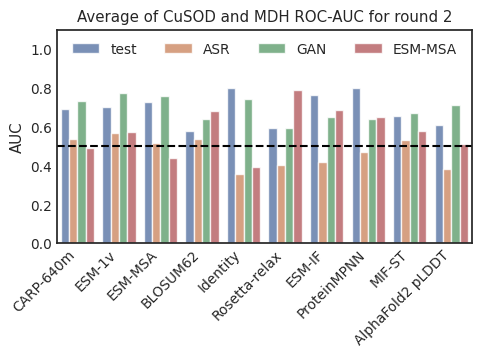

In [6]:
roc_dfs = dict()
families = ("MDH", "CuSOD")
for family in families:
    fpr_by_model = dict()
    tpr_by_model = dict()
    roc_auc_by_model = dict()
    for model_i, model in enumerate([("test",), ("ASR",), ("GAN",), ("ESM-MSA",), ("test", "ASR", "GAN", "ESM-MSA")]):
        metric_i = 0
        df = experimentally_tested_metrics[
        (experimentally_tested_metrics['Round'] == 'round2') &
        (experimentally_tested_metrics['Model'].isin(model)) &
        (experimentally_tested_metrics['Family'] == family)
        ]

        if model == ("test", "ASR", "GAN", "ESM-MSA"):
            model = "all"
        elif model == ("ASR", "GAN", "ESM-MSA"):
            model = "generated"
        else:
            model = model[0]
        roc_auc_by_model[model] = dict()

        for metric in ALL_METRICS:
            fpr_by_model[(model, metric)], tpr_by_model[(model, metric)], _ = roc_curve( df['Activity'], df[metric])
            roc_auc_by_model[model][metric] = auc(fpr_by_model[(model, metric)], tpr_by_model[(model, metric)])
    roc_dfs[family] = pd.DataFrame(roc_auc_by_model)

roc_dfs["average"] = (roc_dfs["MDH"] + roc_dfs["CuSOD"]) / 2

_ = sns.set(font_scale=0.9)
_ = sns.set_style('white')

fig, ax = plt.subplots(figsize=(5,3.7))
#display.display(roc_df.melt(value_vars=["test","ASR","GAN","ESM-MSA"], ignore_index=False, var_name="model", value_name="AUC"))
roc_df_melted = roc_dfs["average"].melt(value_vars=["test","ASR","GAN","ESM-MSA"], ignore_index=False, var_name="Model", value_name="AUC").sort_values("AUC", ascending=False) # add ["all"] to value_vars
# display.display(roc_df_melted)
roc_df_melted["Family"] = family

#order = roc_df_melted[roc_df_melted["Model"] == "all"].index.copy()
plot = sns.barplot(data=roc_df_melted, x=roc_df_melted.index, y="AUC", hue="Model", ax=ax, hue_order=MODEL_HUE_ORDER, order=MAIN_TEXT_METRICS, alpha=0.8) # add ["all"] to value_vars
ax.set_xticklabels(ax.get_xticklabels(),
                  rotation=45,
                  horizontalalignment='right')
ax.axhline(0.5, color="black", linestyle="--")
ax.set_ylim(0, 1.1)
ax.tick_params(pad=-3)
handles, labels = ax.get_legend_handles_labels()
ax.get_legend().remove()
ax.legend(handles, labels, ncol=4, loc='upper center', 
               bbox_to_anchor=(0.5, 1), frameon=False)

# ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
_ = ax.set_title('Average of CuSOD and MDH ROC-AUC for round 2')
fig.tight_layout()
fig.savefig(f"{outdir}/round2_AUCs_average_barplot.png", dpi=300)
#fig.show()


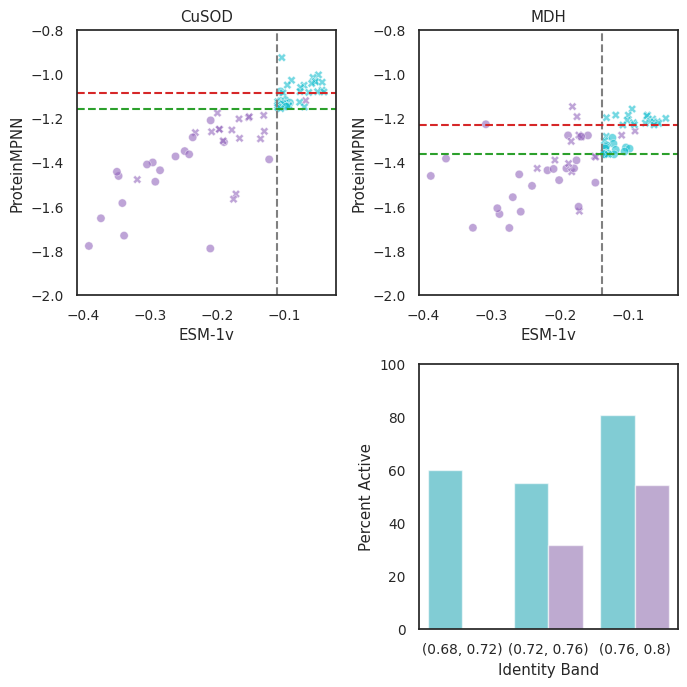

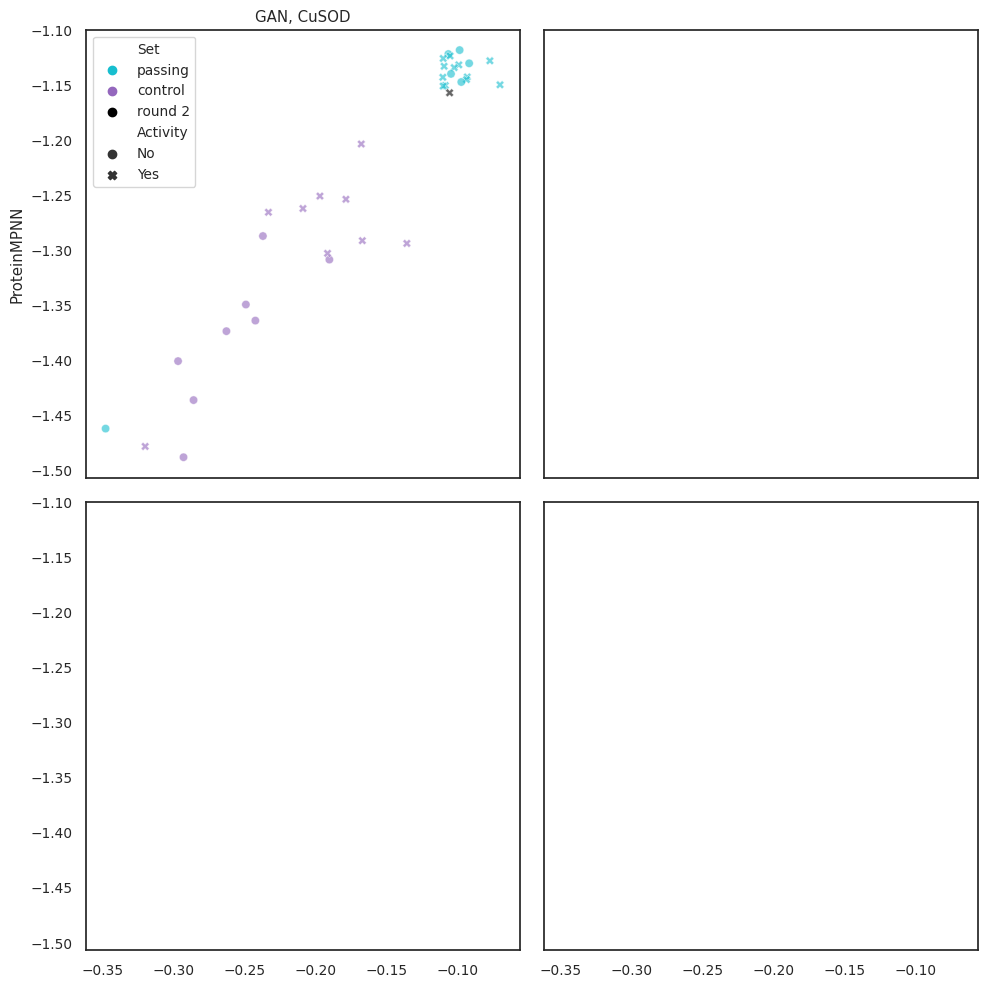

In [7]:
#combos = (("GAN","CuSOD"), ("ESM-MSA", "CuSOD"), ("GAN", "MDH"), ("ESM-MSA", "MDH")) 

fig, axes = plt.subplots(2,2,  figsize=(7,7))
esm1v_cutoffs = {'CuSOD': -0.111278511583805, 'MDH': -0.1379929780960083}
MPNN_cutoffs = {'GAN': {'CuSOD': -1.1572, 'MDH': -1.3644}, 'ESM-MSA': {'CuSOD': -1.0861, 'MDH': -1.2315}}
model_colors = {'GAN': "#2ca02c", 'ESM-MSA': '#d62728'}
model_category_colors = {'GAN-passing': "#2ca02c",'GAN-control': "#2ca02c", 'ESM-MSA-passing': '#d62728', 'ESM-MSA-control': '#d62728'}
for i, family in enumerate(("CuSOD", "MDH")):
    
    df = experimentally_tested_metrics[
        (experimentally_tested_metrics['Round'] == 'round3') &
        #((experimentally_tested_metrics['Model'].isin(["GAN-passing","ESM-MSA-passing]) | (experimentally_tested_metrics['Model'] == model +"-control")) & 
        (experimentally_tested_metrics['Family'] == family)
    ]
    df = df.copy()
    df["Set"] = df["Model"].str.split("-").map(lambda x: x[-1])
    axes[0][i].axvline(esm1v_cutoffs[family], color="grey", linestyle="--")
    for model in ("GAN", "ESM-MSA"):
        axes[0][i].axhline(MPNN_cutoffs[model][family], color=model_colors[model], linestyle="--")
    ax = sns.scatterplot(x="ESM-1v", y="ProteinMPNN", data=df, alpha=0.6, hue="Set", palette=set_colors_map, style="Activity", style_order=ACTIVITY_STYLE_ORDER, ax=axes[0][i])
    #ax = sns.scatterplot(x="ESM-1v", y="ProteinMPNN", data=df, alpha=0.6, hue="Model", palette=model_category_colors, style="Activity", style_order=ACTIVITY_STYLE_ORDER, ax=axes[0][i])
    ax.set_title(f"{family}")
    ax.get_legend().remove()
    #plot += 1
    ax.set_ylim((-2, -0.8))
    # fig.show()
    
    #fig, ax = plt.subplots()
#    sns.stripplot(data=df, x="Activity", y="Identity", hue="Set", ax=axes[1], hue_order=SET_HUE_ORDER, order=[0,1], alpha=0.6)
    
    # sns.kdeplot(data=df[df["Activity"] == 0], x="Identity", linestyle="-", hue="Set", hue_order=SET_HUE_ORDER, ax=axes[2])#, common_norm=False)  #not active
    # sns.kdeplot(data=df[df["Activity"] == 1], x="Identity", linestyle="--", hue="Set", hue_order=SET_HUE_ORDER, ax=axes[2])#, common_norm=False) #active
    #print(df[df["Activity"] == 1])
#fig.tight_layout()
#fig.show()
#plt.savefig(f"{outdir}/round3_fig_{x}_{y}.png", dpi=300)

#fig, axes = plt.subplots(1,2,  figsize=(8,4))

df = experimentally_tested_metrics[
    (experimentally_tested_metrics['Round'] == 'round3')
    #((experimentally_tested_metrics['Model'].isin(["GAN-passing","ESM-MSA-passing]) | (experimentally_tested_metrics['Model'] == model +"-control")) & 
#    (experimentally_tested_metrics['Family'] == family)
].copy()
df["Set"] = df["Model"].str.split("-").map(lambda x: x[-1])
# sns.stripplot(data=df, x="Activity", y="Identity", hue="Set", ax=axes[1][0], hue_order=SET_HUE_ORDER, order=[0,1], alpha=0.6)
# axes[1][0].set_xticklabels(["No","Yes"])
#fig.show()

# sns.kdeplot(data=df[df["Activity"] == 0], x=metric, linestyle="-", hue="Set", hue_order=SET_HUE_ORDER, linewidth=1, ax=axes[1])#, common_norm=False)
# sns.kdeplot(data=df[df["Activity"] == 1], x=metric, linestyle="--", hue="Set", hue_order=SET_HUE_ORDER, linewidth=1, ax=axes[1])#, common_norm=False)

banded = {"Set":list(), "Identity Band": list(), "Percent Active":list(), "Count":list(), "Active":list()}
for band in ((0.68,0.72),(0.72,0.76),(0.76,0.80)):
    for set_ in ("passing","control"):
        sub_df = df[(df["Identity"] > band[0]) & (df["Identity"] <= band[1]) & (df["Set"] == set_)]
        active = sum(sub_df["Activity"])
        total = len(sub_df)
        banded["Set"].append(set_)
        banded["Identity Band"].append(str(band))
        banded["Percent Active"].append(100 * (active / total))
        banded["Count"].append(total)
        banded["Active"].append(active)
#pd.DataFrame(banded)
#print(sum(banded["Count"]))
sns.barplot(data=pd.DataFrame(banded), x="Identity Band", y="Percent Active",  hue="Set",  palette=set_colors_map, ax=axes[1][1], alpha=0.6)
axes[1][1].set_ylim(0,100)
axes[1][1].get_legend().remove()
#pd.DataFrame(banded)

fig.delaxes(axes[1][0])
fig.tight_layout()
fig.show()
fig.savefig(f"{outdir}/round3_summary_fig.svg", dpi=300)


fig, axes = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(10,10))
plot = 0
for model, family in (("GAN","CuSOD"),):
    df = experimentally_tested_metrics[
        (experimentally_tested_metrics['Round'] == 'round3') &
        ((experimentally_tested_metrics['Model'] == model +"-passing") | (experimentally_tested_metrics['Model'] == model +"-control")) & 
        (experimentally_tested_metrics['Family'] == family)
    ]
    df = df.copy()
    df["Set"] = df["Model"].str.split("-").map(lambda x: x[-1])
    
    df.loc[212, "Set"]="passing"
    df.loc[390, "Set"]="round 2"
    ax = sns.scatterplot(x="ESM-1v", y="ProteinMPNN", data=df, alpha=0.6, ax=axes[plot // 2, plot % 2], hue="Set", palette=set_colors_map, style="Activity", style_order=ACTIVITY_STYLE_ORDER)
    # if y == "ESM-1v":
    #     ax.axhline(esm1v_cutoffs[family], color="grey", linestyle="--")
    # if x == "ProteinMPNN":
    #     ax.axvline(MPNN_cutoffs[family], color="grey", linestyle="--")
    ax.set_title(f"{model}, {family}")
    legend=ax.legend()
    for text in legend.get_texts():
        if text.get_text() == "0":
            text.set_text("No")
        if text.get_text() == "1":
            text.set_text("Yes")
    plot += 1
    plt.tight_layout()
    fig.show()
    plt.savefig(f"{outdir}/round3_fig_legend.svg")

# Supplementary figures

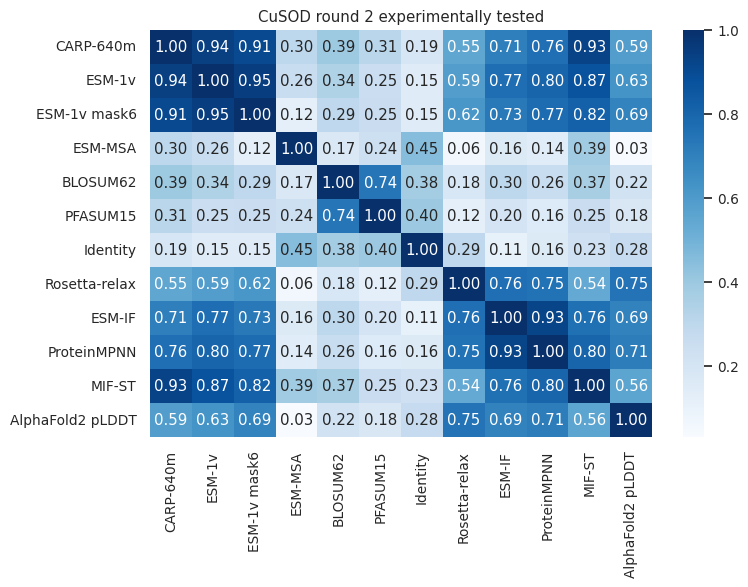

In [8]:
family = "CuSOD"
plt.figure(figsize = (8,6))
df = experimentally_tested_metrics[
    (experimentally_tested_metrics['Round'] == 'round2') &
    (experimentally_tested_metrics['Model'] != "pre-test" ) & 
    (experimentally_tested_metrics['Family'] == family)
]
sns.heatmap(df[ALL_METRICS].corr("spearman"), annot=True, fmt='.2f', cmap=heatmap_cmap)
plt.title(f"{family} round 2 experimentally tested")
plt.tight_layout()
plt.savefig(f"{outdir}/round2_supplemental_metrics_{family}.png", dpi=300)

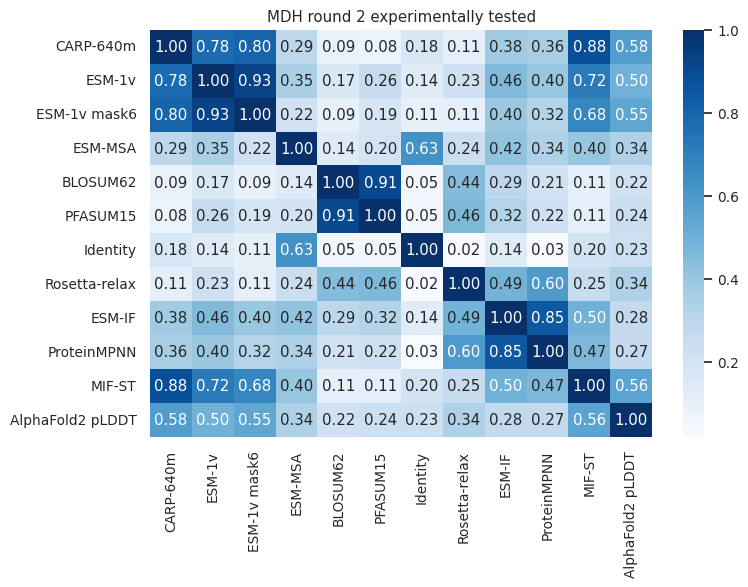

In [9]:
family = "MDH"
plt.figure(figsize = (8,6))
df = experimentally_tested_metrics[
    (experimentally_tested_metrics['Round'] == 'round2') &
    (experimentally_tested_metrics['Model'] != "pre-test" ) & 
    (experimentally_tested_metrics['Family'] == family)
]
sns.heatmap(df[ALL_METRICS].corr("spearman"), annot=True, fmt='.2f', cmap=heatmap_cmap)
plt.title(f"{family} round 2 experimentally tested")
plt.tight_layout()
plt.savefig(f"{outdir}/round2_supplemental_metrics_{family}.png", dpi=300)

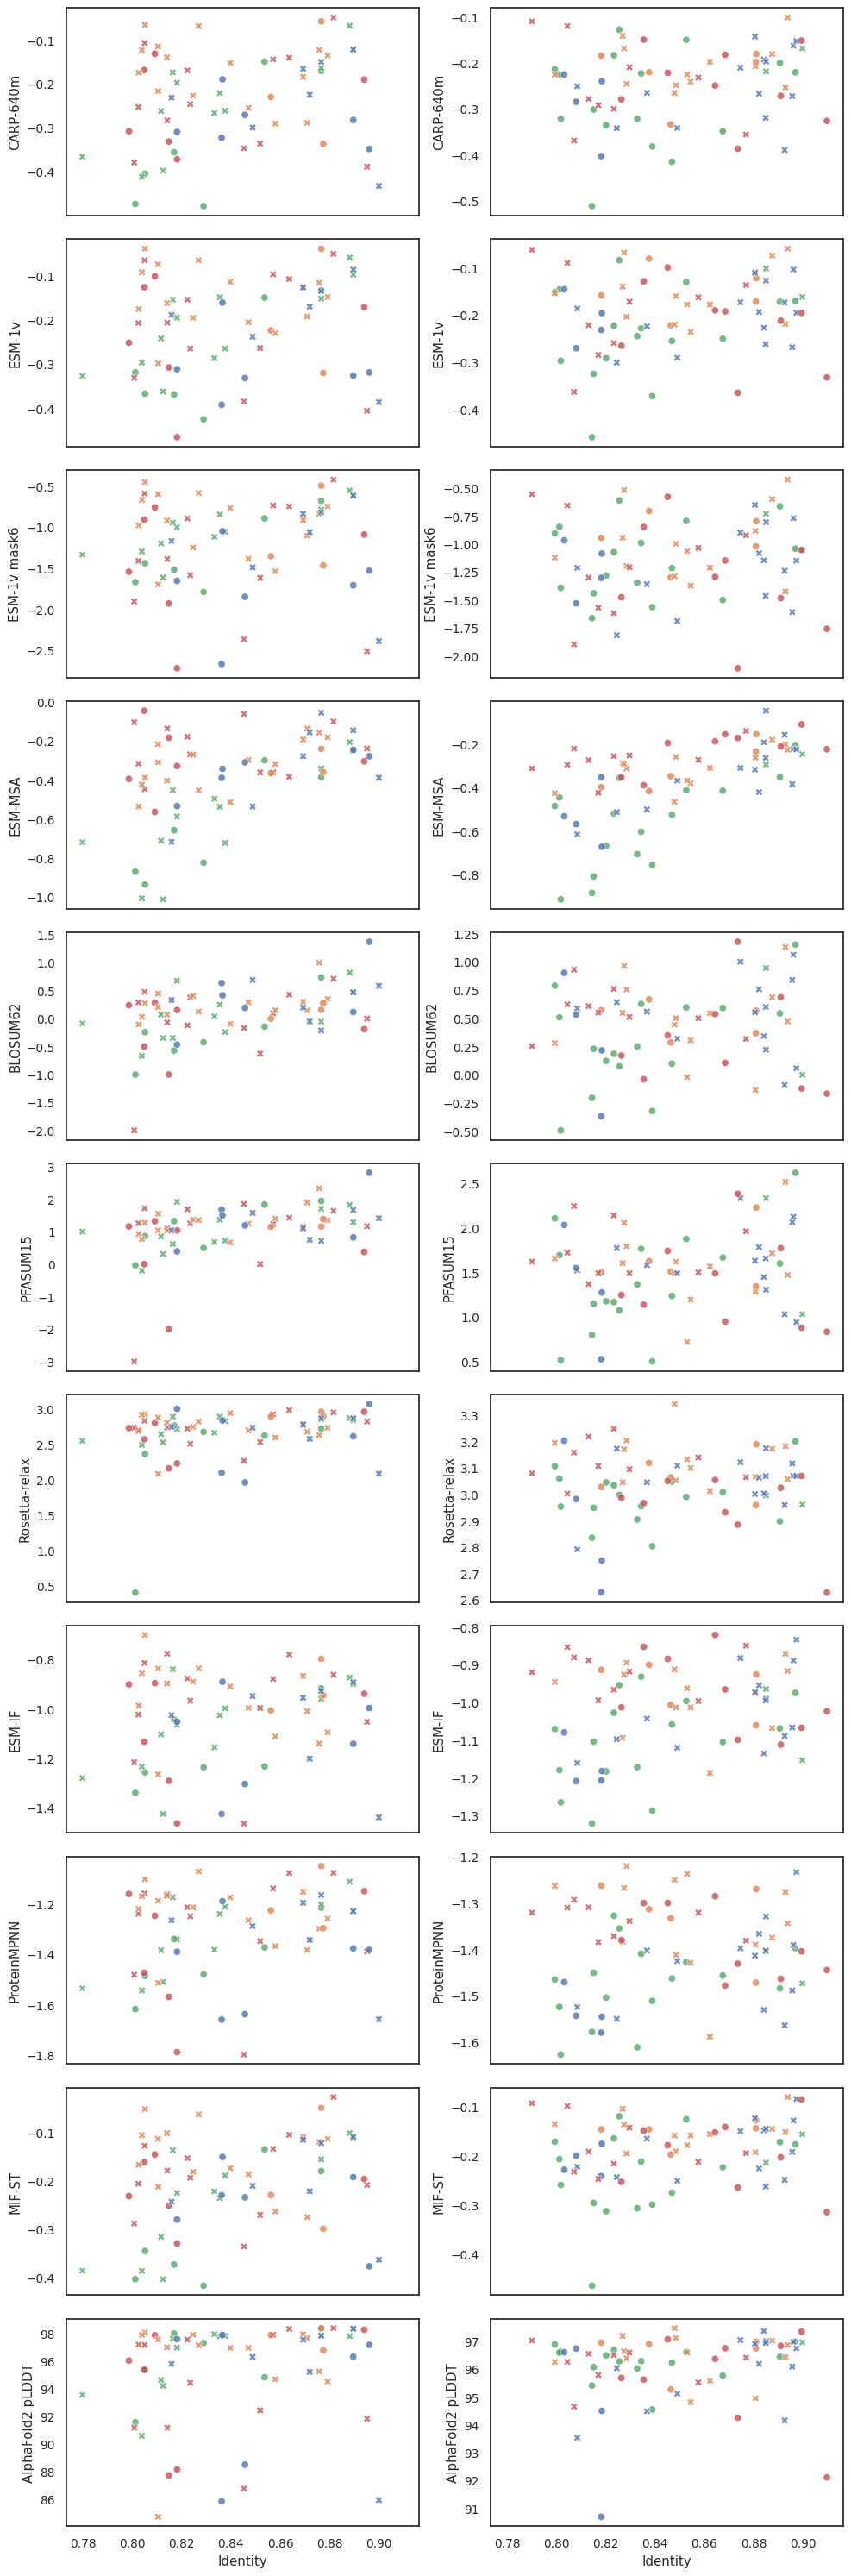

In [10]:
fig, axes = plt.subplots(len(ALL_METRICS) - 1, 2, sharex=True, sharey=False, figsize=(10,30))
for family_i, family in enumerate(["CuSOD", "MDH"]):
    metric_i = 0
    df = experimentally_tested_metrics[
    (experimentally_tested_metrics['Round'] == 'round2') &
    (experimentally_tested_metrics['Model'] != "pre-test" ) & 
    (experimentally_tested_metrics['Family'] == family)
    ]
    for metric in ALL_METRICS:
        if metric == "Identity":
            continue
        ax = sns.scatterplot(x="Identity", y=metric, data=df, alpha=0.8, ax=axes[metric_i, family_i], hue="Model", hue_order=MODEL_HUE_ORDER, style="Activity", style_order=ACTIVITY_STYLE_ORDER)
        metric_i += 1
        ax.get_legend().remove()
plt.tight_layout()
plt.savefig(f"{outdir}/round2_supplemental_metrics_vs_identity_CuSOD_left_MDH_right.png", dpi=300)

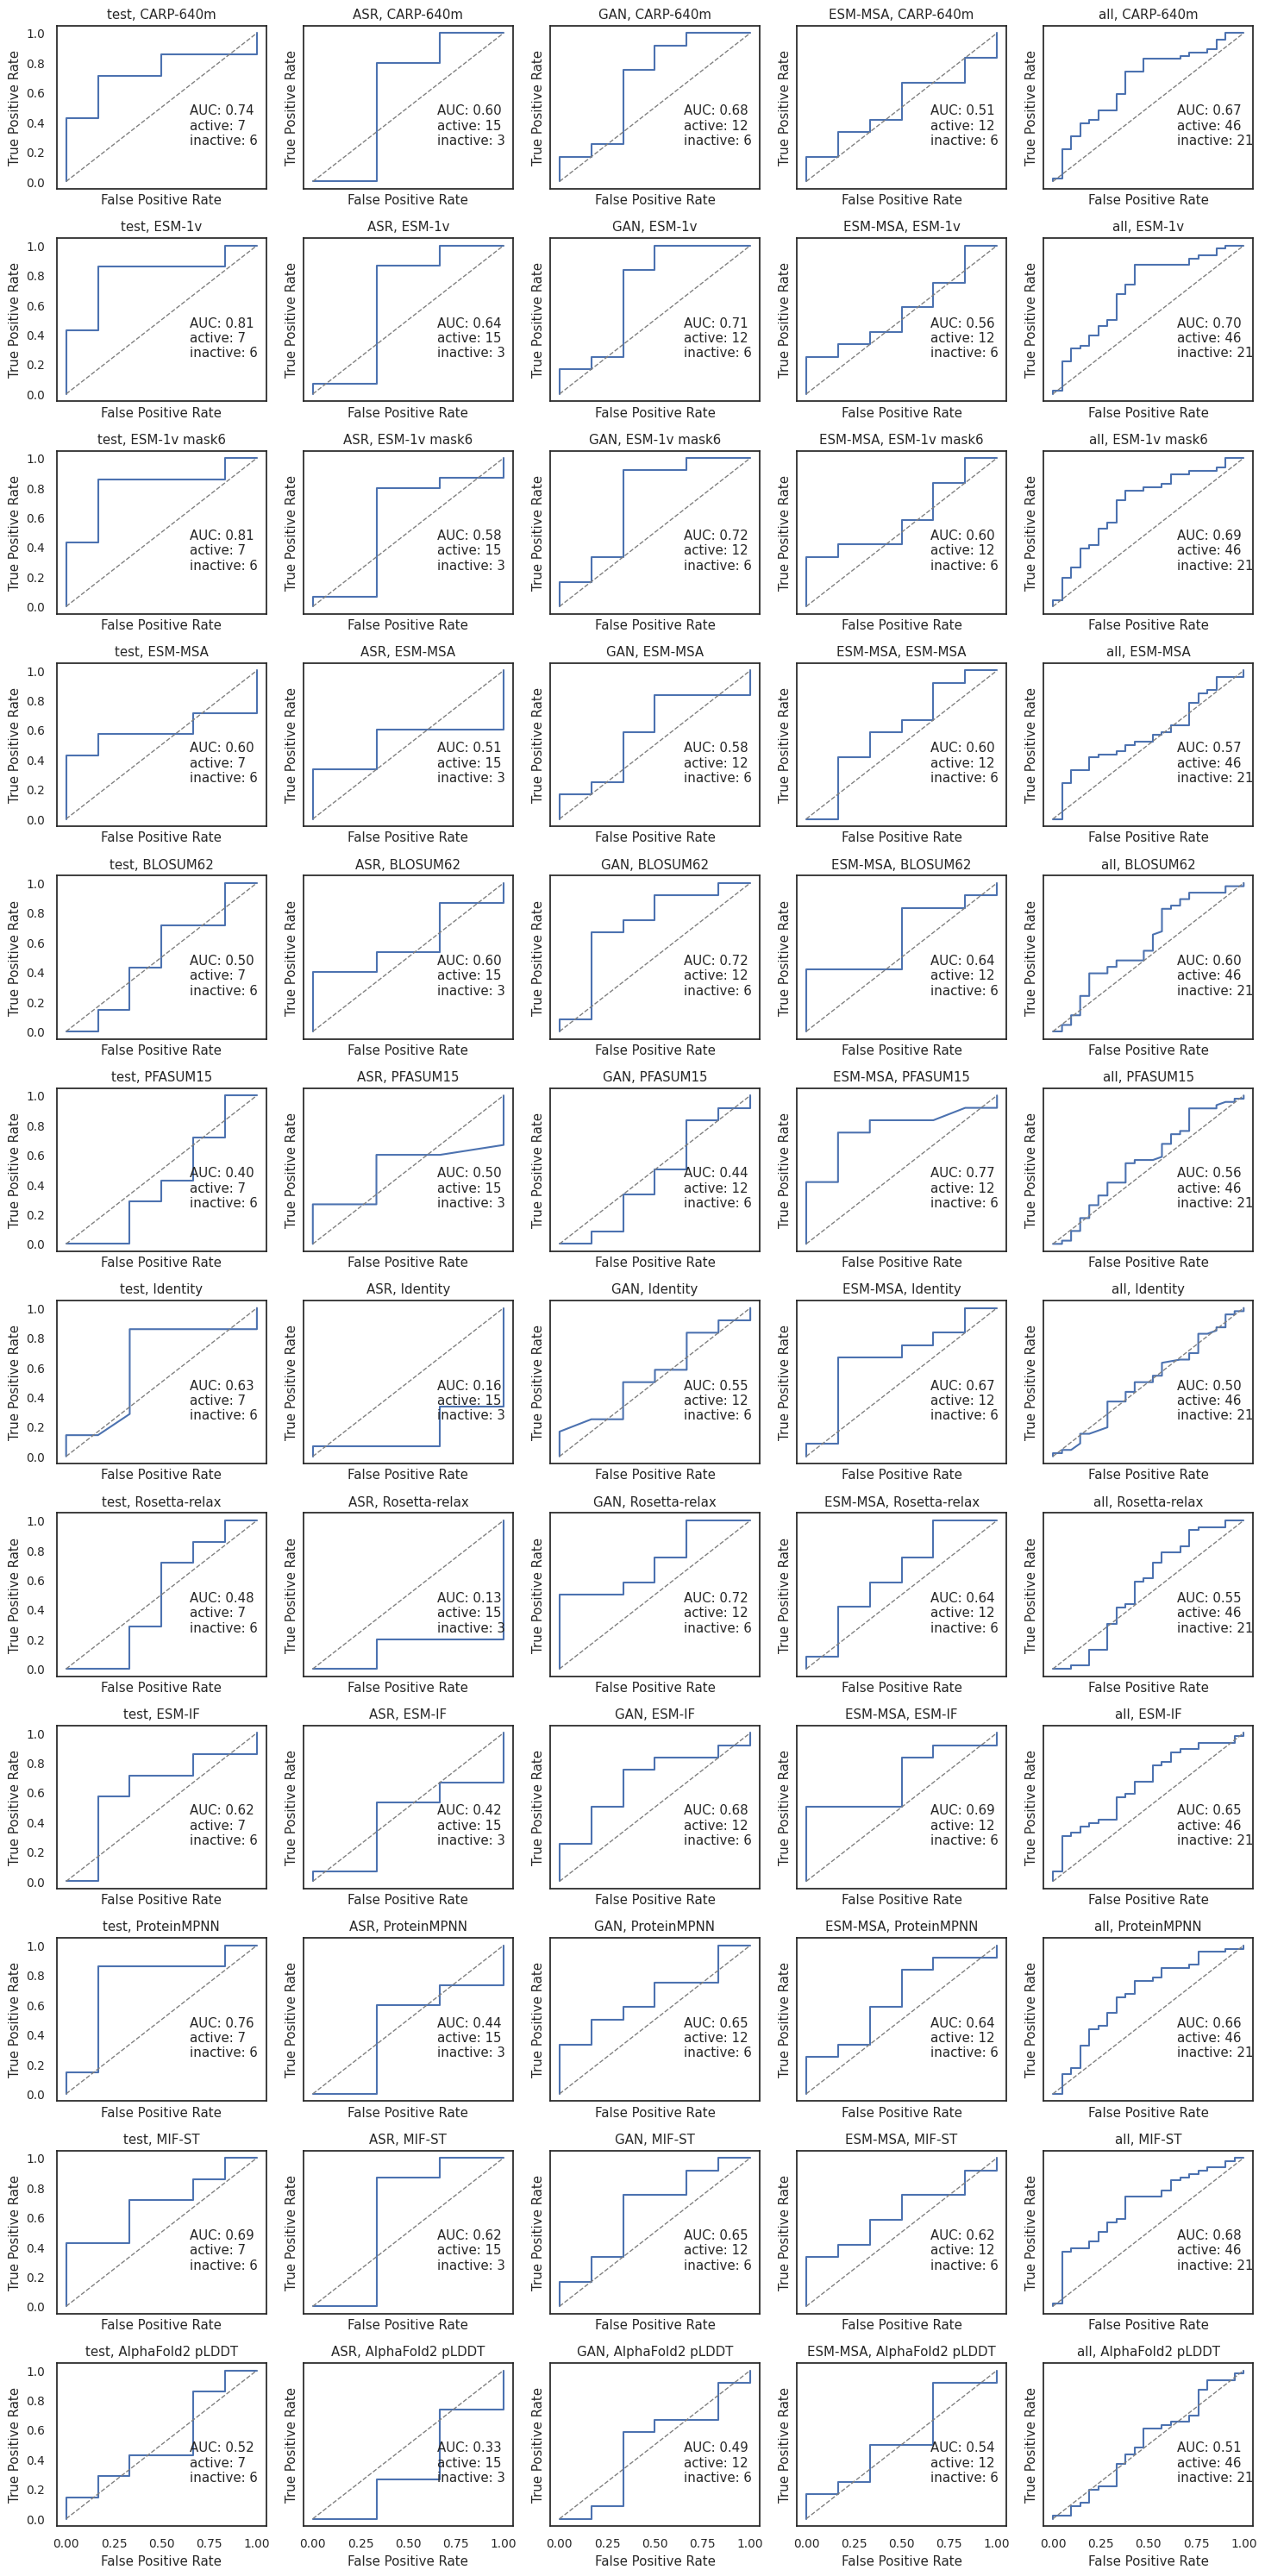

In [11]:
fig, axes = plt.subplots(len(ALL_METRICS), 5, sharex=True, sharey='row', figsize=(15,30))
family = "CuSOD"
for model_i, model in enumerate([("test",), ("ASR",), ("GAN",), ("ESM-MSA",), ("test", "ASR", "GAN", "ESM-MSA")]):
    metric_i = 0
    df = experimentally_tested_metrics[
    (experimentally_tested_metrics['Round'] == 'round2') &
    (experimentally_tested_metrics['Model'].isin(model)) & 
    (experimentally_tested_metrics['Family'] == family)
    ]
    
    if model == ("test", "ASR", "GAN", "ESM-MSA"):
        model = "all"
    else:
        model = model[0]
    
    for metric in ALL_METRICS:
            
        fpr, tpr, _ = roc_curve( df["Activity"], df[metric])
        auc_value = auc(fpr, tpr)
        roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr)
        roc_display.plot(axes[metric_i, model_i])
        lw=1
        roc_display.ax_.plot([0, 1], [0, 1], color="gray", lw=lw, linestyle="--")
        metric_i += 1
        num_active = df["Activity"].sum()
        num_inactive = df["Activity"].size - num_active
        roc_display.ax_.text(.65,.25, f"AUC: {auc_value:0.2f}\nactive: {num_active}\ninactive: {num_inactive}")
        roc_display.ax_.set_title(f"{model}, {metric}")
        #ax.get_legend().remove()
plt.tight_layout()
plt.savefig(f"{outdir}/round2_supplemental_AUCs_{family}.png", dpi=300)

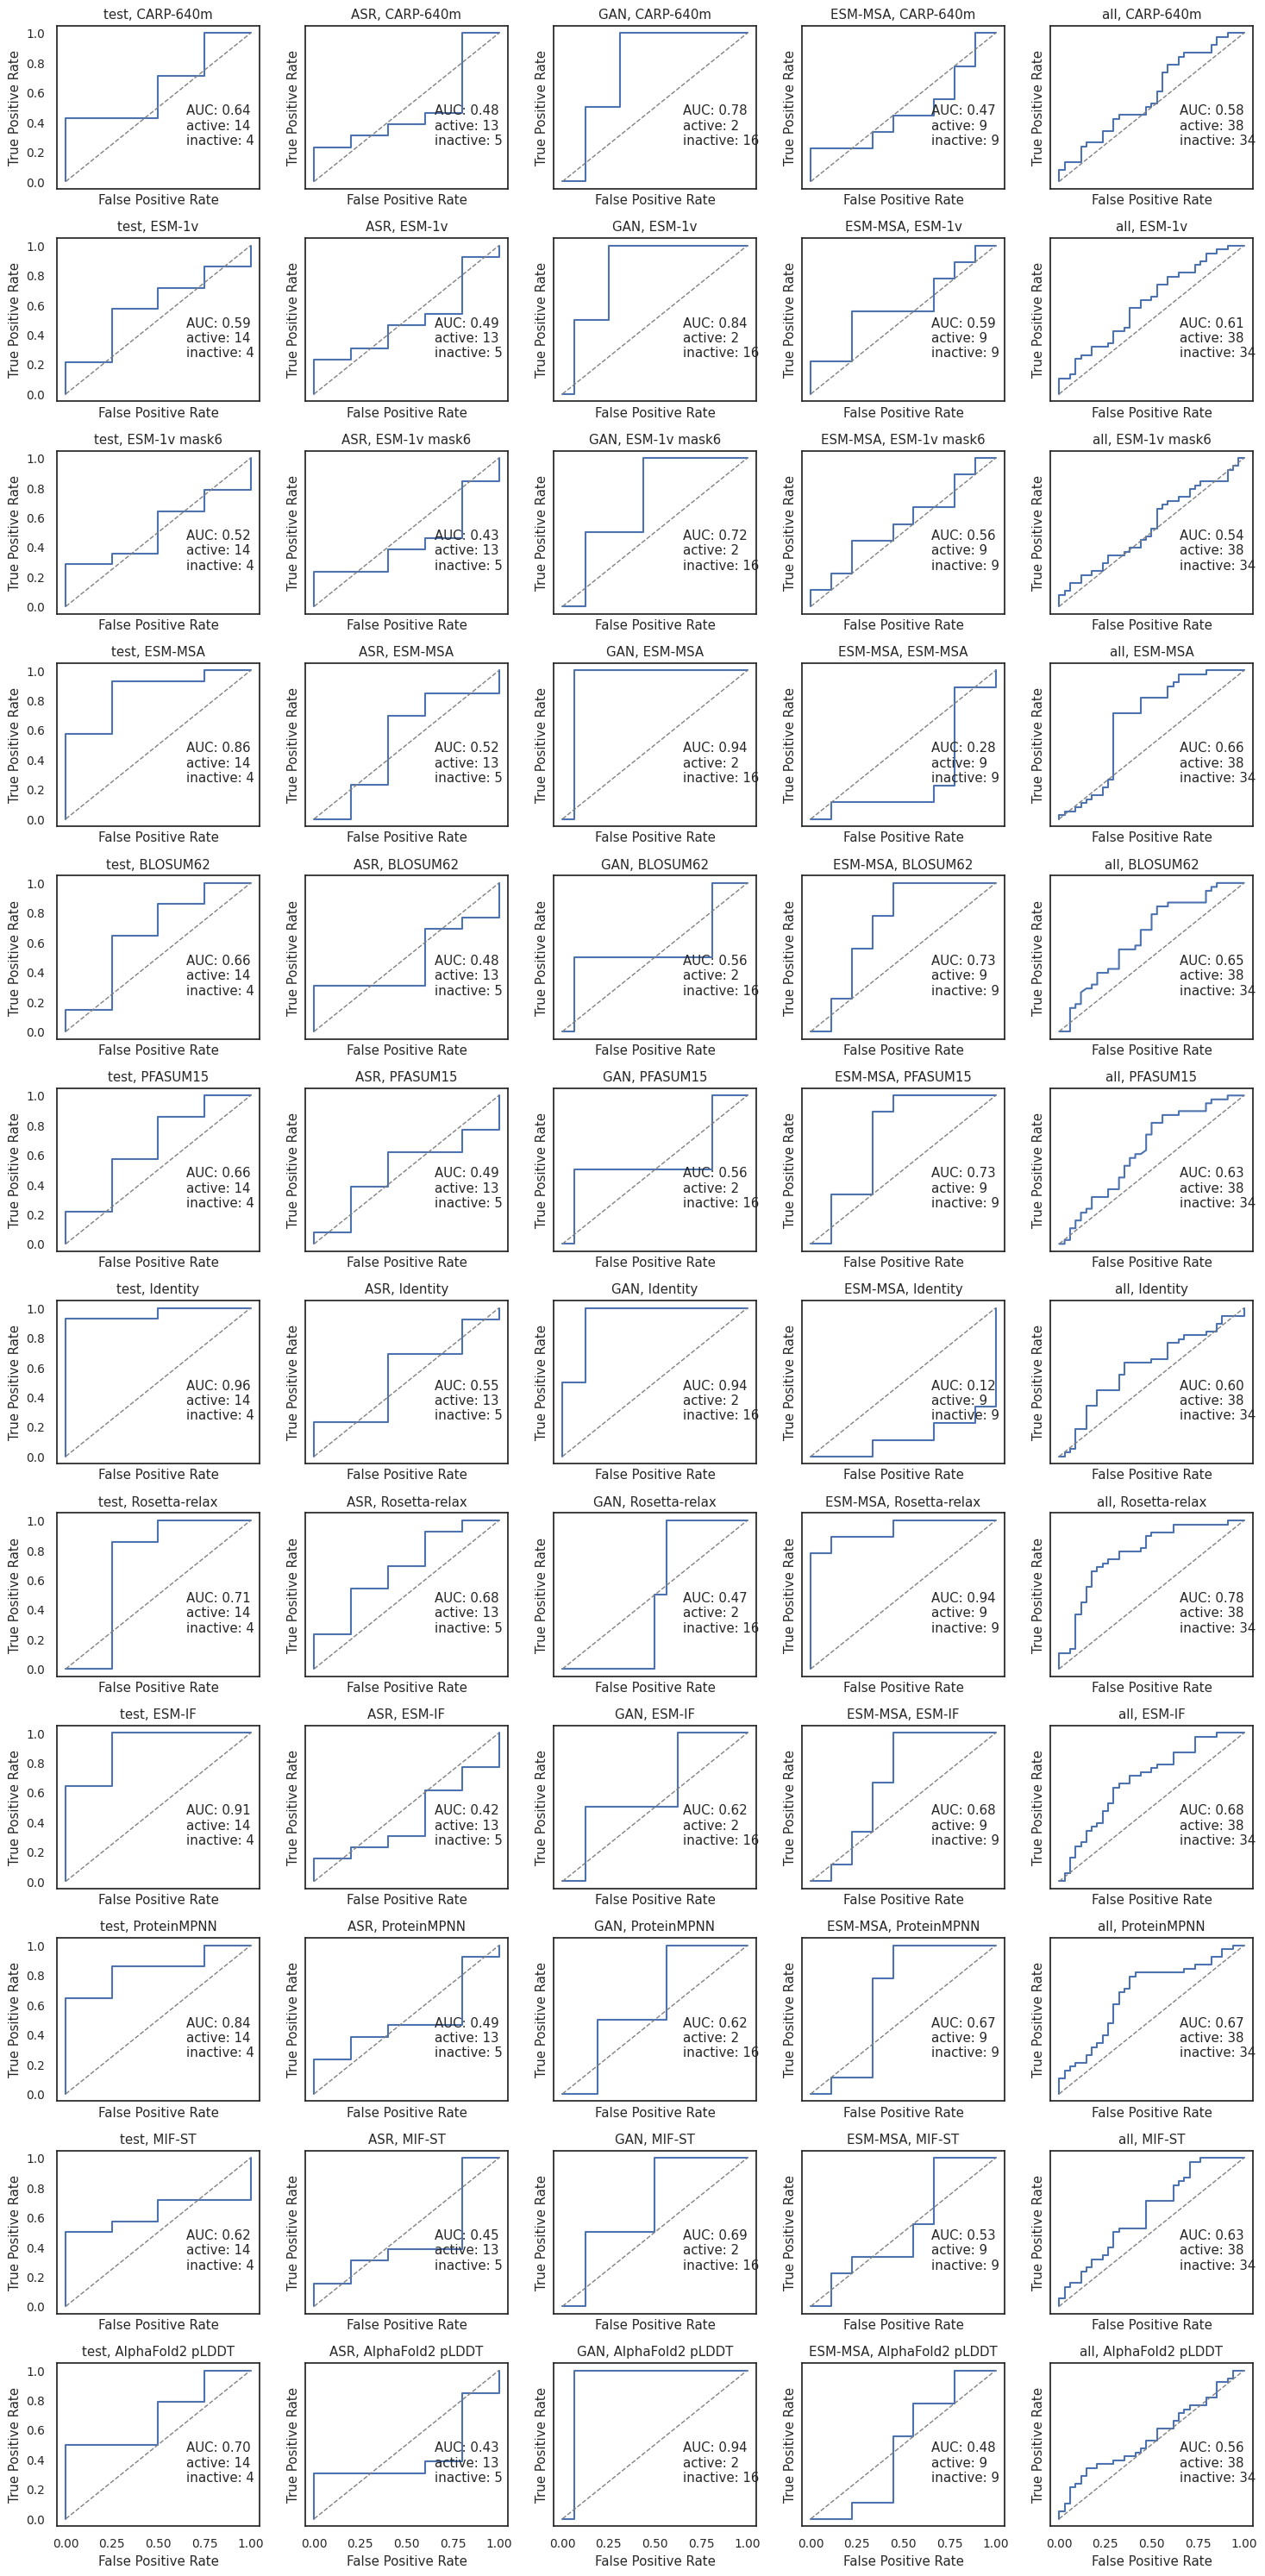

In [12]:
fig, axes = plt.subplots(len(ALL_METRICS), 5, sharex=True, sharey=True, figsize=(15,30))
family = "MDH"
for model_i, model in enumerate([("test",), ("ASR",), ("GAN",), ("ESM-MSA",), ("test", "ASR", "GAN", "ESM-MSA")]):
    metric_i = 0
    df = experimentally_tested_metrics[
    (experimentally_tested_metrics['Round'] == 'round2') &
    (experimentally_tested_metrics['Model'].isin(model)) & 
    (experimentally_tested_metrics['Family'] == family)
    ]
    
    if model == ("test", "ASR", "GAN", "ESM-MSA"):
        model = "all"
    else:
        model = model[0]
    
    for metric in ALL_METRICS:
            
        fpr, tpr, _ = roc_curve( df["Activity"], df[metric])
        auc_value = auc(fpr, tpr)
        roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr)
        roc_display.plot(axes[metric_i, model_i])
        lw=1
        roc_display.ax_.plot([0, 1], [0, 1], color="gray", lw=lw, linestyle="--")
        metric_i += 1
        num_active = df["Activity"].sum()
        num_inactive = df["Activity"].size - num_active
        roc_display.ax_.text(.65,.25, f"AUC: {auc_value:0.2f}\nactive: {num_active}\ninactive: {num_inactive}")
        roc_display.ax_.set_title(f"{model}, {metric}")
        #ax.get_legend().remove()
plt.tight_layout()
plt.savefig(f"{outdir}/round2_supplemental_AUCs_{family}.png", dpi=300)

In [13]:
def precision_curve(x,y, percentile = False, reverse=True):
    """
        x: a list of reals
        y: a list of bools (Positive vs Negative)
        percentile: if True then the first column of output is percentile otherwise it is x

        returns:
            a numpy array with three columns, x (or percentile x), and cumulative positive rate up to x, y (sorted with x).

    """
#    x_precentile = [percentileofscore(x,z) for z in x] #probably not very efficient because it has to sort x each time, later versions of scipy stats can do it in one call.
    arr = np.array([x,y]).T
    arr = arr[arr[:,0].argsort()][::-1]
    arr_len = arr.shape[0]
#     print(f"  0%: {arr[0,0]:0.2f}")
#     print(f" 25%: {arr[math.ceil(arr_len*0.25),0]:0.2f}")
#     print(f" 50%: {arr[math.ceil(arr_len*0.5),0]:0.2f}")
#     print(f" 75%: {arr[math.ceil(arr_len*0.75),0]:0.2f}")
#     print(f"100%: {arr[arr_len-1,0]:0.2f}")
    
    
    cumulative_precision = np.zeros((arr_len))

    positives = 0 
    total = 0
    
    for i in range(arr_len):
        total += 1
        if arr[i, 1]:
            positives += 1
        cumulative_precision[i] = positives/total
        
    if percentile:
        percentile_vals = (np.array(range(arr_len)).T +1) / arr_len
        out = np.stack( (percentile_vals, cumulative_precision, arr[:, 1]) ).T
    else:
        out = np.stack( (arr[:,0], cumulative_precision, arr[:, 1]) ).T

    return out

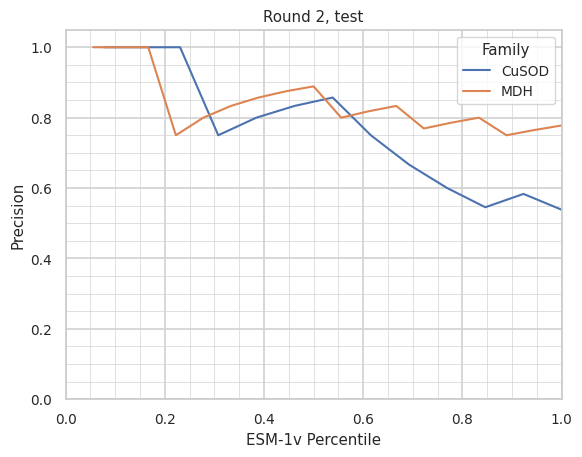

In [14]:
metric = "ESM-1v"
model = "test"
family="CuSOD"

dataframes = list()
for family in ("CuSOD", "MDH"):
    df = experimentally_tested_metrics[
        (experimentally_tested_metrics['Round'] == 'round2') &
        (experimentally_tested_metrics['Model'] == model) & 
        (experimentally_tested_metrics['Family'] == family)
        ]

    pc = pd.DataFrame(precision_curve(df[metric], df["Activity"], percentile=True),columns=[metric + " Percentile", "Precision", "Active"])
    pc["Family"] = family
    dataframes.append(pc)

pcs = pd.concat(dataframes, ignore_index=True)
sns.set_style("whitegrid") # change theme so we can see the ticks
ax = sns.lineplot(x=metric + " Percentile", y="Precision", data=pcs, hue="Family")
ax.get_xaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
ax.grid(visible=True, which='minor', color='lightgrey', linewidth=0.5)
ax.grid(visible=True, which='major', color='lightgrey', linewidth=1.25)
ax.set_title("Round 2, " + model )
plt.ylim(0, 1.05)
plt.xlim(0, 1.00)
sns.reset_orig()
plt.savefig(f"{outdir}/round2_supplemental_test_cumulative_precision.png", dpi=300)

In [15]:
fig, axes = plt.subplots(len(ALL_METRICS), 2,sharex=True, sharey=True, figsize=(8,30))
#'GAN-passing': "#2ca02c",'GAN-control': "#2ca02c", 'ESM-MSA-passing': '#d62728', 'ESM-MSA-control'
for family_i, family in enumerate(["CuSOD", "MDH",]):
    metric_i = 0
    #print(experimentally_tested_metrics)
    df = experimentally_tested_metrics[
    (experimentally_tested_metrics['Round'] == 'round3') &
    (experimentally_tested_metrics['Family'] == family)
    ]
    for metric in ALL_METRICS:
        fpr, tpr, _ = roc_curve( df["Activity"], df[metric])
        auc_value = auc(fpr, tpr)
        roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr)
        roc_display.plot(axes[metric_i, family_i])
        lw=1
        roc_display.ax_.plot([0, 1], [0, 1], color="gray", lw=lw, linestyle="--")
        metric_i += 1
        num_active = df["Activity"].sum()
        num_inactive = df["Activity"].size - num_active
        roc_display.ax_.text(.65,.25, f"AUC: {auc_value:0.2f}\nactive: {num_active}\ninactive: {num_inactive}")
        roc_display.ax_.set_title(f"{family}, {metric}")
        #ax.get_legend().remove()
plt.tight_layout()
plt.savefig(f"{outdir}/round3_supplemental_AUCs.png", dpi=300)

In [16]:
from scipy.stats import ranksums
df = experimentally_tested_metrics[
    (experimentally_tested_metrics['Round'] == 'round2') &
    (experimentally_tested_metrics['Model'] != "pre-test" ) &
    (experimentally_tested_metrics['Model'] != "test" )
#    (experimentally_tested_metrics['Family'] != "MDH" )
]

positives = df[df["Activity"] == 1]
negatives = df[df["Activity"] == 0]

for metric in MAIN_TEXT_METRICS:
    print(metric)
    print(ranksums(positives[metric], negatives[metric]).pvalue)

CARP-640m
0.025480760197678608
ESM-1v
0.0196092854897929
ESM-MSA
0.06834151428300847
BLOSUM62
0.29227523375787534
Identity
0.5834293529670465
Rosetta-relax
0.8007469400518237
ESM-IF
0.0060505762494669985
ProteinMPNN
0.00020905704221927993
MIF-ST
0.014700335908077702
AlphaFold2 pLDDT
0.305315436252643


In [17]:
from scipy.stats import ranksums
for family in ("MDH", "CuSOD"):
    df = experimentally_tested_metrics[
        (experimentally_tested_metrics['Round'] == 'round3') &
        (experimentally_tested_metrics['Model'] != "pre-test" ) &
    #    (experimentally_tested_metrics['Model'] != "test" )
        (experimentally_tested_metrics['Family'] == family )
    ]

    positives = df[df["Activity"] == 1]
    negatives = df[df["Activity"] == 0]
    print(family)
    for metric in MAIN_TEXT_METRICS:
        print(metric)
        print(ranksums(positives[metric], negatives[metric]).pvalue)
    print()

MDH
CARP-640m
2.289375861461047e-05
ESM-1v
4.789126585572956e-05
ESM-MSA
3.885083541816482e-08
BLOSUM62
0.28975682581457063
Identity
0.3920342801698051
Rosetta-relax
5.39459725914134e-07
ESM-IF
1.4337126821520305e-06
ProteinMPNN
6.811244052358554e-07
MIF-ST
8.583049675699235e-07
AlphaFold2 pLDDT
0.0006990558114112923

CuSOD
CARP-640m
1.7688475335705572e-06
ESM-1v
4.2451788453132606e-06
ESM-MSA
0.6846355413516495
BLOSUM62
0.08219940867785674
Identity
0.17899221322310077
Rosetta-relax
0.0007233676217404558
ESM-IF
8.587007326540045e-07
ProteinMPNN
2.0032346734765337e-05
MIF-ST
2.3112465611631824e-07
AlphaFold2 pLDDT
0.001679949872605273



In [18]:
from scipy.stats import fisher_exact

fisher_exact([[52,20],[32,40]])

(3.25, 0.001231766214467604)